# Fake Job Classification Detection
### Daniel Chen


## Introduction

The unemployment rate in the United States acording to the US Department of Labor as of June 2020 is at 11.1%$^1$. Although there are many factors causing contributing to the current unemployment rate, many people in the US and worldwide need to look for new jobs due to job loss and other financial hardships. As all of the job postings are done online now, most companies can directly post to job boards or have job data pulled from job aggregators. However, not all job postings are true job postings as some are fradulent job postings used to harvest data or other sensitive information towards desperate job seekers$^2$. Using the advances in natural learning processing, it should be possible to build a classifier to be able to detect potential fake jobs. This is an important task as many people will be applying for jobs online due to the current unemployment situation, and minimizing victims of scams due to fradulent job postings will be important for economic recovery.

Using data gathered from the University of Aegean about various job postings from many different job sites, it should be possible to build some a classifer for potential fake job postings. Job posts typically are text rich with general job descriptions and typically some additional information such as telecommuting options and employment type. With all of these features, it should be possible to build a complex model using features from the job description using NLP or even more simple features with simplier models. This project will use three models and with the most simple model being the baseline model to compare against.

1. Simple model using non-NLP features such as comparing correlations of job function to fraudulent postings
2. Intermediate model using NLP tokenization features and modeling relationship of fraudent job postings using more traditional machine learning algorithms such as logistic regression or SVMs
3. Complex model using state of the art transformer neural network models to predict fradulent job postings 

## Data Description
The dataset originally was downloaded from [kaggle](https://www.kaggle.com/shivamb/real-or-fake-fake-jobposting-prediction). The dataset hosted there is originally from the [University of Aegean](http://emscad.samos.aegean.gr/). This dataset is a publicly available dataset containing almost ~18,000 job ads with human classified fake jobs. This dataset is based on job ads published between 2012 and 2014. There are ~17000 true jobs and ~900 fake jobs in the dataset.  

Basic exploratory data analysis will be done to help guide future development.




### Exploratory Data Analysis

In [ ]:
# Mount google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import spacy
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
fake_job_postings = pd.read_csv("/content/drive/My Drive/nlp_class/fake_job_postings.csv")
fake_job_postings.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function,fraudulent
0,1,Marketing Intern,"US, NY, New York",Marketing,NaN,"We're Food52, and we've created a groundbreaki...","Food52, a fast-growing, James Beard Award-winn...",Experience with content management systems a m...,NaN,0,1,0,Other,Internship,NaN,NaN,Marketing,0
1,2,Customer Service - Cloud Video Production,"NZ, , Auckland",Success,NaN,"90 Seconds, the worlds Cloud Video Production ...",Organised - Focused - Vibrant - Awesome!Do you...,What we expect from you:Your key responsibilit...,What you will get from usThrough being part of...,0,1,0,Full-time,Not Applicable,NaN,Marketing and Advertising,Customer Service,0
2,3,Commissioning Machinery Assistant (CMA),"US, IA, Wever",NaN,NaN,Valor Services provides Workforce Solutions th...,"Our client, located in Houston, is actively se...",Implement pre-commissioning and commissioning ...,NaN,0,1,0,NaN,NaN,NaN,NaN,NaN,0
3,4,Account Executive - Washington DC,"US, DC, Washington",Sales,NaN,Our passion for improving quality of life thro...,THE COMPANY: ESRI – Environmental Systems Rese...,"EDUCATION: Bachelor’s or Master’s in GIS, busi...",Our culture is anything but corporate—we have ...,0,1,0,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Sales,0
4,5,Bill Review Manager,"US, FL, Fort Worth",NaN,NaN,SpotSource Solutions LLC is a Global Human Cap...,JOB TITLE: Itemization Review ManagerLOCATION:...,QUALIFICATIONS:RN license in the State of Texa...,Full Benefits Offered,0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Hospital & Health Care,Health Care Provider,0


We can see various features including numerical one hot encoded variables and text data. The one hot encoded variables seem to be information about telecommuting, company logos, and if there are questions included in the posting. The text data include general information including job titles, locations, department, company information, job description and more. The variable we are interested in predicting is `fradulent`. 

##### Basic Data Quality

In [ ]:
fake_job_postings.shape

(17880, 18)

There are about 18000 postings and 16 features that we can use. We also need to look at the potential missing data.

In [ ]:
fake_job_postings.isnull().sum() / len(fake_job_postings) * 100

job_id                  0.000000
title                   0.000000
location                1.935123
department             64.580537
salary_range           83.959732
company_profile        18.501119
description             0.005593
requirements           15.072707
benefits               40.324385
telecommuting           0.000000
has_company_logo        0.000000
has_questions           0.000000
employment_type        19.412752
required_experience    39.429530
required_education     45.329978
industry               27.421700
function               36.101790
fraudulent              0.000000
dtype: float64

In the output above, we can see the percentage of missing data in each column in the dataset. The column with the largest amount of missing data is the salary which makes sense followed by department. With the amount of missing data, some columns not might be too useful but that also depends on the relative ratio based on fradulent job posts.

In [ ]:
fake_job_postings.groupby("fraudulent").count()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function
fraudulent,,,,,,,,,,,,,,,,,
0,17014,17014,16687,5998,2645,14293,17014,14473,10168,17014,17014,17014,13784,10399,9360,12386,10896
1,866,866,847,335,223,279,865,712,502,866,866,866,625,431,415,591,529


In the table above, we can see the number of fraudulent job postings against all of the variables. We have 866 fraduent jobs which is very small compared to the relative amount of non fraudulent jobs. 

In [ ]:
fake_job_postings.groupby("fraudulent").count().iloc[1,] / fake_job_postings.groupby("fraudulent").count().sum() * 100

job_id                 4.843400
title                  4.843400
location               4.830615
department             5.289752
salary_range           7.775453
company_profile        1.914631
description            4.838078
requirements           4.688838
benefits               4.704780
telecommuting          4.843400
has_company_logo       4.843400
has_questions          4.843400
employment_type        4.337567
required_experience    3.979686
required_education     4.245524
industry               4.554211
function               4.630197
dtype: float64

Looking at it another way, most of our fradulent job postings only account for 5% of each feature so there is some data sparsity issues.

In [ ]:
fake_job_postings.title.nunique()

11231

There are 11231 unique job titles

In [ ]:
fake_job_postings.department.nunique()


1337

There are 1337 unique departments.

In [ ]:
fake_job_postings.location.nunique()


3105

There are job postings for 3105 different locations.

In [ ]:
fake_job_postings.employment_type.value_counts()

Full-time    11620
Contract      1524
Part-time      797
Temporary      241
Other          227
Name: employment_type, dtype: int64

We can see the different types of employment types in this dataset.

In [ ]:
fake_job_postings.telecommuting.value_counts()

0    17113
1      767
Name: telecommuting, dtype: int64

Most of the jobpostings are not telecommute friendly.

In [ ]:
fake_job_postings.has_questions.value_counts()

0    9088
1    8792
Name: has_questions, dtype: int64

It seems like half of the job postings has additional questions.

In [ ]:
fake_job_postings.has_company_logo.value_counts()

1    14220
0     3660
Name: has_company_logo, dtype: int64

It seems like most of the job postings has a company logo.

In [ ]:
fake_job_postings.required_education.value_counts()

Bachelor's Degree                    5145
High School or equivalent            2080
Unspecified                          1397
Master's Degree                       416
Associate Degree                      274
Certification                         170
Some College Coursework Completed     102
Professional                           74
Vocational                             49
Some High School Coursework            27
Doctorate                              26
Vocational - HS Diploma                 9
Vocational - Degree                     6
Name: required_education, dtype: int64

In the table above, we can see that the jobs mostly require High School education or above.

In [ ]:
fake_job_postings.required_experience.value_counts()

Mid-Senior level    3809
Entry level         2697
Associate           2297
Not Applicable      1116
Director             389
Internship           381
Executive            141
Name: required_experience, dtype: int64

It seems like a lot of the jobs are entry level to senior level.

In [ ]:
fake_job_postings.industry.value_counts()

Information Technology and Services    1734
Computer Software                      1376
Internet                               1062
Marketing and Advertising               828
Education Management                    822
                                       ... 
Ranching                                  1
Alternative Dispute Resolution            1
Shipbuilding                              1
Wine and Spirits                          1
Museums and Institutions                  1
Name: industry, Length: 131, dtype: int64

From this table, the top industry appears to be tech or tech related.

In [ ]:
fake_job_postings.function.value_counts()

Information Technology    1749
Sales                     1468
Engineering               1348
Customer Service          1229
Marketing                  830
Administrative             630
Design                     340
Health Care Provider       338
Other                      325
Education                  325
Management                 317
Business Development       228
Accounting/Auditing        212
Human Resources            205
Project Management         183
Finance                    172
Consulting                 144
Art/Creative               132
Writing/Editing            132
Production                 116
Product Management         114
Quality Assurance          111
Advertising                 90
Business Analyst            84
Data Analyst                82
Public Relations            76
Manufacturing               74
General Business            68
Research                    50
Legal                       47
Strategy/Planning           46
Training                    38
Supply C

Finally, from this we see that these jobs are mostly sales or tech related.

#### Fradulent Comparison

In [ ]:
fake_job_postings.groupby(['fraudulent','telecommuting']).size()

fraudulent  telecommuting
0           0                16311
            1                  703
1           0                  802
            1                   64
dtype: int64

We can see that most of the fake jobs are not tele commute friendly.

In [ ]:
fake_job_postings.groupby(['fraudulent','function']).size().to_frame().sort_values(by=['fraudulent', 0 ])

0
fraudulent function              
0          Science             14
           Purchasing          15
           Distribution        21
           Financial Analyst   28
           Supply Chain        36
...                           ...
1          Other               32
           Sales               41
           Customer Service    67
           Engineering        113
           Administrative     119

[64 rows x 1 columns]

Most of the fake jobs are in the administrative or engineering groups.

In [ ]:
fake_job_postings.groupby(['fraudulent','industry']).size().to_frame().sort_values(by=['fraudulent', 0 ])

0
fraudulent industry                           
0          Alternative Dispute Resolution    1
           Military                          1
           Museums and Institutions          1
           Shipbuilding                      1
           Sporting Goods                    1
...                                        ...
1          Financial Services               35
           Marketing and Advertising        45
           Hospital & Health Care           51
           Accounting                       57
           Oil & Energy                    109

[192 rows x 1 columns]

Most of the fradulent jobs appear to be coming from the energy sector.

In [ ]:
fake_job_postings.groupby(['fraudulent','required_experience']).size().to_frame().sort_values(by=['fraudulent', 0 ])

0
fraudulent required_experience      
0          Executive             131
           Internship            371
           Director              372
           Not Applicable       1056
           Associate            2255
           Entry level          2518
           Mid-Senior level     3696
1          Executive              10
           Internship             10
           Director               17
           Associate              42
           Not Applicable         60
           Mid-Senior level      113
           Entry level           179

Most of the fradulent jobs are entry to senior level careers.

In [ ]:
fake_job_postings.groupby(['fraudulent','required_education']).size().to_frame().sort_values(by=['fraudulent', 0 ])

0
fraudulent required_education                     
0          Vocational - Degree                   6
           Some High School Coursework           7
           Vocational - HS Diploma               9
           Doctorate                            25
           Vocational                           49
           Professional                         70
           Some College Coursework Completed    99
           Certification                       151
           Associate Degree                    268
           Master's Degree                     385
           Unspecified                        1336
           High School or equivalent          1910
           Bachelor's Degree                  5045
1          Doctorate                             1
           Some College Coursework Completed     3
           Professional                          4
           Associate Degree                      6
           Certification                        19
           Some High School Coursework          20
           Master's Degree                      31
           Unspecified                          61
           Bachelor's Degree                   100
           High School or equivalent           170

The highest number of fake job postings required High School or Bachelor's degrees.

In [ ]:
fake_job_postings.groupby(['fraudulent','has_company_logo']).size()

fraudulent  has_company_logo
0           0                    3077
            1                   13937
1           0                     583
            1                     283
dtype: int64

It seems like fradulent job postings have twice as many missing logos than with logos.

In [ ]:
fake_job_postings.groupby(['fraudulent','has_questions']).size()

fraudulent  has_questions
0           0                8472
            1                8542
1           0                 616
            1                 250
dtype: int64

Real job postings have and don't have questions at about the same ratio. These fake jobs have 3 times more missing questions than questions.

#### Salary Comparison

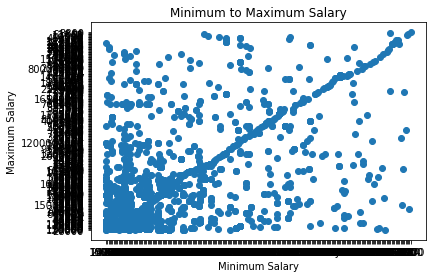

In [ ]:
min_salary = [item[1].split("-")[0] for item in fake_job_postings.salary_range.dropna().iteritems()]
max_salary = [item[1].split("-")[1] if len(item[1].split("-")) > 1 else '0' for item in fake_job_postings.salary_range.dropna().iteritems()]
fig=plt.figure()
plt.scatter(min_salary, max_salary)
plt.title('Minimum to Maximum Salary')
plt.xlabel('Minimum Salary')
plt.ylabel('Maximum Salary')
plt.show()


We can see that the salary ranges are mostly clustered at the lower end. From where, we interestingly have a linear line as well as a bunch of outliers.

#### Length Comparison

In [ ]:
word_length = fake_job_postings[['title', 'location', 'department', 'company_profile', 'description', 'requirements', 'benefits', 'required_education', 'employment_type', 'required_experience', 'industry', 'function']].fillna('').astype(str).apply(lambda x:x.str.len())
word_length.iloc[fake_job_postings[fake_job_postings["fraudulent"] == 1].index].mean() # Fake Average


title                    30.666282
location                 14.872979
department                5.058891
company_profile         230.891455
description            1154.834873
requirements            446.049654
benefits                212.196305
required_education        9.382217
employment_type           6.375289
required_experience       6.144342
industry                 12.158199
function                  7.904157
dtype: float64

The above are the average length for the fake jobs. 

In [ ]:
word_length.iloc[fake_job_postings[fake_job_postings["fraudulent"] == 0].index].mean() # Real Average

title                    28.421594
location                 15.336311
department                3.679558
company_profile         640.752674
description            1221.219701
requirements            597.466146
benefits                208.728165
required_education        9.731339
employment_type           7.154579
required_experience       7.627718
industry                 14.057952
function                  8.367991
dtype: float64

The above is the average character lengths for the real jobs. Most variables are about the same length but the biggest difference comes from the company profile and the requirements. 

#### NLP Analysis of Longer text

First, we need to get an understanding fo the text data and how it looks raw before designing a tokenizer.

##### Title

In [ ]:
fake_job_postings[fake_job_postings["fraudulent"] == 1].title.sample(10, random_state = 0)

8027                                    Well Test Operator
3194     Home Based Payroll Typist/Data Entry Clerks Po...
17597                                 FRONT OFFICE MANAGER
4967                            Military Benefits Advocate
2483                        Customer Service Administrator
17655                         Controls Engineer - Troy, MI
6877                             Electrical Technician III
11550                                         SEO Analysis
5926                                  Assistant Accountant
5870                             Receptionist Office Asst.
Name: title, dtype: object

This is the fradulent job titles. This sample looks mostly normal.

In [ ]:
fake_job_postings[fake_job_postings["fraudulent"] == 0].title.sample(10, random_state = 0)

13092    Sr. MS Dynamics Consultant ( AX or GP )
13436                Software Engineer - Android
17502                 TWIC or RAPIDGate Laborers
10820               Agent-Inbound Sales Position
2067               Internship (Media production)
15735                          Executive Analyst
2535                        Data Account Analyst
6142              Cook / Assistant Cook - Meigle
13695                             UX/UI Designer
15945                             CNC Programmer
Name: title, dtype: object

This is the sample of the title for real jobs. This still looks normal.

##### Location

In [ ]:
fake_job_postings[fake_job_postings["fraudulent"] == 1].location.sample(10, random_state = 0)

8027          US, TX, Houston
3194        US, AL, Abernant 
17597        US, OH, COLUMBUS
4967                 US, IL, 
2483      US, CA, LOS ANGELES
17655            US, MI, Troy
6877          US, TX, Houston
11550       US, CA, San Mateo
5926                   AU, , 
5870     US, FL, Jacksonville
Name: location, dtype: object

The fraduluent locations seem normal.

In [ ]:
fake_job_postings[fake_job_postings["fraudulent"] == 0].location.sample(10, random_state = 0)

13092                  EG, C, Maadi
13436         US, CA, San Francisco
17502              US, CT, Hartford
10820     US, PA, Robinson Township
2067                         GR, , 
15735               GB, LND, London
2535                US, NJ, Hoboken
6142     GB, PKN, Perth and Kinross
13695                   KR, , Seoul
15945           US, CA, Los Angeles
Name: location, dtype: object

The real job postings still look normal.

It seems that some cities are capitialized and some are not. Additionally, it looks like the job postings are intereational and thus, can be missing parts after the comma separation.

##### Department

In [ ]:
fake_job_postings[fake_job_postings["fraudulent"] == 1].dropna().department.sample(10, random_state = 0)

5808      \tCorporate Shared Services
5838                    Oil & Energy 
8680                          Account
4607                       CALLCENTER
6505                         SECURITY
8836                            MAINT
937                 Refined Resources
11739                    Oil & Energy
6528                      CALLCENTER 
17813                Customer Service
Name: department, dtype: object

For the fake jobs, we do actually see a lot of energy related jobs.

In [ ]:
fake_job_postings[fake_job_postings["fraudulent"] == 0].dropna().department.sample(10, random_state = 0)

13785                        Marketing 
11844                         Technical
13906                       Development
14599                             Sales
12975                        Leadership
298                               DTVMA
776                               Sales
9249     Sales and Business Development
8010                                 IT
12364               A Techstars Company
Name: department, dtype: object

For the real jobs, it looks like real departments and then potentially misclassification as seen by the techstars company.

##### Description

In [ ]:
fake_job_postings[fake_job_postings["fraudulent"] == 1].dropna().description.sample(1, random_state = 0).iloc[0]

'Act as a first point of contact for employee-related issues, conducting intake meetings with employees and/or managers who contact the Employee Relations Center of Excellence (COE) and helping to resolve concerns, address performance issues and work through escalated complaints or issues through providing coaching, mediation, consultation, corrective action and training. Provide advice, guidance and support to management and HR Business Partners, in partnership with the Employee Relations Leader, to efficiently address a wide array of employee conduct and performance-related issues, keeping appropriate parties apprised of the status and associated recommendations, as appropriate. Effectively develop and administer (in partnership with management) required corrective action and/or developmental action plans, as required. Partner with human resources and Legal leadership to design, cascade and promote standardized processes, templates, tools and/or technologies for use in managing emplo

This fake job posting looks almost normal. It does not name a company and references a department and seems to not be a finished job posting judging by the end.

In [ ]:
fake_job_postings[fake_job_postings["fraudulent"] == 0].dropna().description.sample(1, random_state = 0).iloc[0]

'Hayes Corporation is looking for a highly motivated, proactive Product Marketing Assistant with a passion in product marketing and management in mobile and social games.The ideal candidate will manage product advertisement and consumer perspective.The ideal candidate will be able to support multiple product lines through market research.ResponsibilitiesSupporting content publishing within in-game marketing channels. This includes a range of activities such as data entry, proofreading and product quality management.\xa0Collaborate with design and content staff to ensure projects meet consumer objectives and expectations.Assist with various aspects of product marketing including advertising and pricing.Meet quick-to-market expectations.Support multiple product lines simultaneously.Research consumer opinions and marketing approaches to further improve product performance.'

This real job posting names a company and the role name. The spacing is not perfectly parsed and there seems to be some special character encodings in this judging from the `\xa0`

##### Requirements

In [ ]:
fake_job_postings[fake_job_postings["fraudulent"] == 1].dropna().requirements.sample(1, random_state = 0).iloc[0]

'Minimum of three (3) years of work Novationoffers an empowered work environment that encourages creativity, initiative and professional growth and provides a competitive salary and benefits package. Novation is an Equal Employment Opportunity/Affirmative Action Employer and maintains a Drug-Free Workplace. We are fully committed to employing a diverse workforce and creating an inclusive work environment that embraces everyone’s unique contributions, experiences and values. Please apply on our website for #URL_9df44aa03d8a2708a5b7eb9f42cb8dfea4f5ee8bb3e37f676ad1d8031248b996# in an employee relations related field. Experience working in a shared services or COE model preferred. Knowledge of ER procedures and processes such as the proper handling of investigations, employee complaints and corrective actions. Technical understanding of employment laws and employee dispute resolution programs. Excellent written and verbal communication skills. Exceptional customer service focus and orienta

In this fake job posting, we can see that it looks mostly normal. There seems to be some spacing issues for parts of the sentence and it seems like the URLs have been stripped from this corpus.

In [ ]:
fake_job_postings[fake_job_postings["fraudulent"] == 0].dropna().requirements.sample(1, random_state = 0).iloc[0]

'Degree in any Business discipline, preferably MarketingStrong proofreading abilities, a keen eye for detailProficient in MS Office (Excel)Accurate data management, documentation and record-keeping skillsFluent English, both verbal and written. Chinese is helpful, although not necessaryAbility to multi-taskStrong interpersonal communication skills in a multicultural, cross-functional settingStrong understanding of mobile, social networking and gaming arenaResults oriented attitude'

In this real requirement, we see that the spacing between bullets in the requirements is not implemented. 

##### Benefits

In [ ]:
fake_job_postings[fake_job_postings["fraudulent"] == 1].dropna().benefits.sample(1, random_state = 0).iloc[0]

'Novation offers an empowered work environment that encourages creativity, initiative and professional growth and provides a competitive salary and benefits package. Novation is an Equal Employment Opportunity/Affirmative Action Employer and maintains a Drug-Free Workplace. We are fully committed to employing a diverse workforce and creating an inclusive work environment that embraces everyone’s unique contributions, experiences and values. Please apply on our website for consideration.'

This fake benefit seems generic but makes sense.

In [ ]:
fake_job_postings[fake_job_postings["fraudulent"] == 0].dropna().benefits.sample(1, random_state = 0).iloc[0]

'Full Medical after probation13 months discretionary bonus100% English environmentGet to play with the latest gadgets and technologies. eg Apple, Google, Twitter, mobile, Android, etc'

This real benefit has new line or spacing issues.

#### Tokenization and examination of Counts and TF-IDF

From the exploratory analysis, a tokenizer can be built. For now, we are only interested in alpha numeric characters. We can remove stop words, lemmatize the text, and remove some of the junk including the url,  emails, and any additional numbers. 

In [ ]:
from spacy.lang.en import English
nlp = English()

def tokenizer(corpus, model = nlp):
  """
  Tokenizer to keep alpha numeric, remove stop words, lemmatize text , remove url, remove emails, remove numbers
  """
  bag_of_words = nlp(corpus)

  parsed_words = [i.lemma_ for i in bag_of_words if not i.is_stop and i.is_alpha and not i.like_url and not i.like_num and not i.like_email]

  return(parsed_words)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

In [ ]:
def get_top_n_words(bag_of_words, vec, n=None):
    """
    List the top n words in a vocabulary according to occurrence in a text corpus.
    """
    sum_words = bag_of_words.sum(axis=0) 
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq =sorted(words_freq, key = lambda x: x[1], reverse=True)
    return words_freq[:n]

##### Title

In [ ]:
cv_title = CountVectorizer(tokenizer = tokenizer, min_df = 0.01, max_df = 0.99)
cv1_title = cv_title.fit_transform(fake_job_postings.title)
get_top_n_words(cv1_title, cv_title, 5)

[('manager', 2232),
 ('developer', 1828),
 ('engineer', 1620),
 ('sales', 1339),
 ('senior', 988)]

We can see the most frequent are management, and higher level roles. The two most popular direct roles are engineer and sales.

In [ ]:
tf_title = TfidfVectorizer(tokenizer = tokenizer, min_df = 0.01, max_df = 0.99)
tf1_title = tf_title.fit_transform(fake_job_postings.title)
get_top_n_words(tf1_title, tf_title, 5)

[('manager', 1514.7744028970876),
 ('developer', 1266.0328608377754),
 ('engineer', 1197.27209884887),
 ('sales', 914.7238336638629),
 ('senior', 652.0774215198769)]

Using the tf-idf, we get similar results to count vectors. 

In [ ]:
np.mean(cosine_similarity(tf1_title[fake_job_postings[fake_job_postings['fraudulent'] == 0].index], tf1_title[fake_job_postings[fake_job_postings['fraudulent'] == 1].index]))

0.027120795983612972

The above is the cosine similarity between the fradulent and non fradulent jobs using tf-idf. We get almost 0 which is good as we hope they are different.

In [ ]:
np.mean(cosine_similarity(cv1_title[fake_job_postings[fake_job_postings['fraudulent'] == 0].index], cv1_title[fake_job_postings[fake_job_postings['fraudulent'] == 1].index]))

0.029662819148400698

Similarly, when we do the average cosine similarity for counts we get almost 0 which means they are different.

##### Location

In [ ]:
cv_location = CountVectorizer(tokenizer = tokenizer, min_df = 0.01, max_df = 0.99)
cv1_location = cv_location.fit_transform(fake_job_postings.location.fillna(''))
get_top_n_words(cv1_location, cv_location, 5)

[('gb', 2384), ('ny', 1282), ('london', 1132), ('lnd', 992), ('tx', 975)]

The jobs seem mostly located in potentially Great Britain and New York according to the count vectorizer.

In [ ]:
tf_location = TfidfVectorizer(tokenizer = tokenizer, min_df = 0.01, max_df = 0.99)
tf1_location = tf_location.fit_transform(fake_job_postings.location.fillna(''))
get_top_n_words(tf1_location, tf_location, 5)

[('gb', 1775.7610762409133),
 ('ny', 879.1788113958479),
 ('tx', 763.943191261618),
 ('london', 760.1820505886812),
 ('gr', 751.2959167755391)]

According to tf-idf, we get very similar results to the tf-idf.

In [ ]:
np.mean(cosine_similarity(tf1_location[fake_job_postings[fake_job_postings['fraudulent'] == 0].index], tf1_location[fake_job_postings[fake_job_postings['fraudulent'] == 1].index]))

0.01955888139733028

The mean cosine similarity between the fraduelent and non-fraudulent dataset is almost 0.

In [ ]:
np.mean(cosine_similarity(cv1_location[fake_job_postings[fake_job_postings['fraudulent'] == 0].index], cv1_location[fake_job_postings[fake_job_postings['fraudulent'] == 1].index]))

0.020678388171154433

The mean cosine similarity between the fraudulent and non-fraudulent dataset is almost 0 but a bit higher than the count vectorizer.

##### Department

In [ ]:
cv_department = CountVectorizer(tokenizer = tokenizer, min_df = 0.01, max_df = 0.99)
cv1_department = cv_department.fit_transform(fake_job_postings.department.fillna(""))
get_top_n_words(cv1_department, cv_department, 5)

[('sales', 683),
 ('engineering', 552),
 ('marketing', 529),
 ('operations', 330),
 ('development', 312)]

In [ ]:
tf_department = TfidfVectorizer(tokenizer = tokenizer, min_df = 0.01, max_df = 0.99)
tf1_department = tf_department.fit_transform(fake_job_postings.department.fillna(""))
get_top_n_words(tf1_department, tf_department, 5)

[('sales', 666.6055261224266),
 ('engineering', 547.7048161503801),
 ('marketing', 517.4609667166276),
 ('operations', 328.55607485827863),
 ('development', 292.1341240034073)]

We can see that botht he tf-idf and count vectorizer finds the same top hits for department. It seems it is mostly sales and engieering related work that is hiring. 

In [ ]:
np.mean(cosine_similarity(tf1_department[fake_job_postings[fake_job_postings['fraudulent'] == 0].index], tf1_department[fake_job_postings[fake_job_postings['fraudulent'] == 1].index]))

0.003709763571489574

In [ ]:
np.mean(cosine_similarity(cv1_department[fake_job_postings[fake_job_postings['fraudulent'] == 0].index], cv1_department[fake_job_postings[fake_job_postings['fraudulent'] == 1].index]))

0.003713573904059939

For both the TF-IDF and the count vectorizer, we can see that the mean cosine similarity between fraudulent and non-fraudulent job posts is almost 0.

##### Description

In [ ]:
cv_description = CountVectorizer(tokenizer = tokenizer, min_df = 0.01, max_df = 0.99)
cv1_description = cv_description.fit_transform(fake_job_postings.description.fillna(""))
get_top_n_words(cv1_description, cv_description, 5)

[('team', 17715),
 ('work', 14380),
 ('business', 10622),
 ('customer', 9775),
 ('new', 9735)]

In [ ]:
tf_description = TfidfVectorizer(tokenizer = tokenizer, min_df = 0.01, max_df = 0.99)
tf1_description = tf_description.fit_transform(fake_job_postings.description.fillna(""))
get_top_n_words(tf1_description, tf_description, 5)

[('team', 691.9832712113662),
 ('work', 622.5833136797995),
 ('sales', 569.8148090500061),
 ('customer', 536.1533894811573),
 ('experience', 510.0660044225824)]

Comparing the count vectorizer with the tf-idf, we similar job description importance. Using the count vectorizer, we get the most common words being team and work related which is very generic. With tf-idf, we mostly get the same top 5 but also `experience`.

In [ ]:
np.mean(cosine_similarity(tf1_description[fake_job_postings[fake_job_postings['fraudulent'] == 0].index], tf1_description[fake_job_postings[fake_job_postings['fraudulent'] == 1].index]))

0.04615427957813173

In [ ]:
np.mean(cosine_similarity(cv1_description[fake_job_postings[fake_job_postings['fraudulent'] == 0].index], cv1_description[fake_job_postings[fake_job_postings['fraudulent'] == 1].index]))

0.07541392566933681

As seen above, count vectorizer has 5% higher cosine similarity than TF-IDF which means TF-IDF does a better job of distinguishing fraudulent and non fraudulent posts.

##### Requirements

In [ ]:
cv_requirements = CountVectorizer(tokenizer = tokenizer, min_df = 0.01, max_df = 0.99)
cv1_requirements = cv_requirements.fit_transform(fake_job_postings.requirements.fillna(""))
get_top_n_words(cv1_requirements, cv_requirements, 5)

[('experience', 20634),
 ('skills', 10429),
 ('work', 9797),
 ('years', 7848),
 ('ability', 6961)]

In [ ]:
tf_requirements = TfidfVectorizer(tokenizer = tokenizer, min_df = 0.01, max_df = 0.99)
tf1_requirements = tf_requirements.fit_transform(fake_job_postings.requirements.fillna(""))
get_top_n_words(tf1_requirements, tf_requirements, 5)

[('experience', 1244.3437538115788),
 ('skills', 744.7890849017842),
 ('work', 730.014306420189),
 ('years', 631.3315410039722),
 ('ability', 543.8823383123708)]

We get the same top words with both tf-idf and word counts. It seems the most important things people want are skills and experience.

In [ ]:
np.mean(cosine_similarity(tf1_requirements[fake_job_postings[fake_job_postings['fraudulent'] == 0].index], tf1_requirements[fake_job_postings[fake_job_postings['fraudulent'] == 1].index]))

0.03818614280236542

In [ ]:
np.mean(cosine_similarity(cv1_requirements[fake_job_postings[fake_job_postings['fraudulent'] == 0].index], cv1_requirements[fake_job_postings[fake_job_postings['fraudulent'] == 1].index]))

0.07694572197518018

Similar to the job description cosine similarities, we see that the cosine similiarity of count vectorizer to be worse than TF-IDF.

##### Benefits

In [ ]:
cv_benefits = CountVectorizer(tokenizer = tokenizer, min_df = 0.01, max_df = 0.99)
cv1_benefits = cv_benefits.fit_transform(fake_job_postings.benefits.fillna(""))
get_top_n_words(cv1_benefits, cv_benefits, 5)

[('work', 4244),
 ('benefits', 3685),
 ('company', 3259),
 ('competitive', 2916),
 ('team', 2549)]

In [ ]:
tf_benefits = TfidfVectorizer(tokenizer = tokenizer, min_df = 0.01, max_df = 0.99)
tf1_benefits = tf_benefits.fit_transform(fake_job_postings.benefits.fillna(""))
get_top_n_words(tf1_benefits, tf_benefits, 5)

[('benefits', 665.4690645794257),
 ('job', 604.0228903001768),
 ('work', 586.6254547255782),
 ('description', 554.2962404038343),
 ('competitive', 527.0242344247309)]

For the benefits, we get relatively similar results between count vectorizer and tf-idf. 

In [ ]:
np.mean(cosine_similarity(tf1_benefits[fake_job_postings[fake_job_postings['fraudulent'] == 0].index], tf1_benefits[fake_job_postings[fake_job_postings['fraudulent'] == 1].index]))

0.019497645962743327

In [ ]:
np.mean(cosine_similarity(cv1_benefits[fake_job_postings[fake_job_postings['fraudulent'] == 0].index], cv1_benefits[fake_job_postings[fake_job_postings['fraudulent'] == 1].index]))

0.026223827579902097

We also get relatively similar results between the mean cosine similarity between TF-IDF and count vectorizer.

### Modeling

### Feature Engineering

#### Salary

The salary range can be parsed out to use as numeric variables for our model. The salary range seems to include text variables so those need to be removed as well. The NaN values will be initialized at 0 as they are unknown.

In [ ]:
# Parse out the salary
max_salary = []
min_salary = []
for salary in fake_job_postings.salary_range:
  if pd.isnull(salary):
    min_salary.append(0)
    max_salary.append(0)
  else:
    salary_range = salary.split("-")
    if len(salary_range) > 1:
      try:
        min_salary.append(int(salary_range[0]))
      except:
        min_salary.append(0) # If text is input
      try:
        max_salary.append(int(salary_range[1]))
      except:
        max_salary.append(0) # If text is input
    else: # In cases where input is just a single value
      try:
        min_salary.append(int(salary_range[0]))
      except:
        min_salary.append(0) # If text is input
      try:
        max_salary.append(int(salary_range[0]))
      except:
        max_salary.append(0) # If text is input

Next, the salaries need to be normalize as it's mostly 0s. The values are log 10ed in order to minimize the effects of 0 and because the numerical values if present are large.

In [ ]:
from sklearn import preprocessing
max_salary = [np.log10(i + 1) for i in max_salary]
min_salary = [np.log10(i + 1) for i in min_salary]

Then a basic histogram

Text(0.5, 1.0, 'Maximum Salary Histogram')

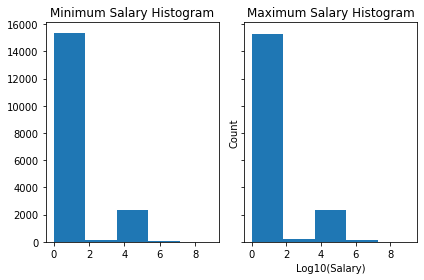

In [ ]:
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].hist(min_salary, bins=5, label = "Min. salary")
axs[1].hist(max_salary, bins=5, label = "Max. salary")
plt.xlabel('Log10(Salary)')
plt.ylabel('Count')
axs[0].set_title('Minimum Salary Histogram')
axs[1].set_title('Maximum Salary Histogram')

As we can see inthe plot above, most of the salaries are NaN or 0. It's very right skewed and there is a small peak again at around 4. It looks like there is a small increase in the maximum salary compared to the minimum salary.

In [ ]:
# Add feature
fake_job_postings["min_salary"] = min_salary
fake_job_postings["max_salary"] = max_salary

#### Augmentation

As there is a severe class imbalance, some text augmentation needs to be done to pad the number of fake jobs as we have a 1:19 classifier. The one hot encoding values can be the same but all of the text needs augmentation.

In [ ]:
# Use nlpaug as a way to augment text data
# Install pre-reqs for nlpaug
!pip install nlpaug
!pip install torch>=1.2.0 transformers>=2.5.0
!pip install nltk>=3.4.5
!pip install pytorch-transformers

import nlpaug.augmenter.char as nac
import nlpaug.augmenter.word as naw
import nlpaug.augmenter.sentence as nas
import nlpaug.flow as nafc

from nlpaug.util import Action

     |████████████████████████████████| 102kB 5.1MB/s 
     |████████████████████████████████| 184kB 10.0MB/s 


In [ ]:
# Insertions
aug = naw.ContextualWordEmbsAug(model_path='bert-base-uncased', action="insert")
i_prof = [aug.augment(profile) if not pd.isnull(profile) else profile for profile in fake_job_postings[fake_job_postings["fraudulent"] == 1]["company_profile"]]
i_descrip = [aug.augment(profile) if not pd.isnull(profile) else profile for profile in fake_job_postings[fake_job_postings["fraudulent"] == 1]["description"]]
i_req = [aug.augment(profile) if not pd.isnull(profile) else profile for profile in fake_job_postings[fake_job_postings["fraudulent"] == 1]["requirements"]]
i_benefits = [aug.augment(profile) if not pd.isnull(profile) else profile for profile in fake_job_postings[fake_job_postings["fraudulent"] == 1]["benefits"]]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForMaskedLM were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['cls.predictions.decoder.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.6/dist-packages/torch/cuda/__init__.py:125: UserWarning: 
Tesla T4 with C

Insertions into the text is done using Bert. This is an artificial augmentation to add some additional context specific words to sound natural while ideally maintaining context. This is only done to the long text such as `company profile` as insertions don't make sense in some columns such as location.

In [ ]:
# Substitution
aug = naw.ContextualWordEmbsAug(model_path='distilbert-base-uncased', action="substitute")
s_title = [aug.augment(profile) if not pd.isnull(profile) else profile for profile in fake_job_postings[fake_job_postings["fraudulent"] == 1]["title"]]
s_department = [aug.augment(profile) if not pd.isnull(profile) else profile for profile in fake_job_postings[fake_job_postings["fraudulent"] == 1]["department"]]
s_company_profile = [aug.augment(profile) if not pd.isnull(profile) else profile for profile in fake_job_postings[fake_job_postings["fraudulent"] == 1]["company_profile"]]
s_description = [aug.augment(profile) if not pd.isnull(profile) else profile for profile in fake_job_postings[fake_job_postings["fraudulent"] == 1]["description"]]
s_requirements = [aug.augment(profile) if not pd.isnull(profile) else profile for profile in fake_job_postings[fake_job_postings["fraudulent"] == 1]["requirements"]]
s_benefits = [aug.augment(profile) if not pd.isnull(profile) else profile for profile in fake_job_postings[fake_job_postings["fraudulent"] == 1]["benefits"]]

We are interested in substituing the corpora. Assuming that the meaning is somewhat similar, it should not give us any detriments for augmentation.

In [ ]:
# Synonym
## Download NLTK's synonym db
import nltk
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')

aug = naw.SynonymAug(aug_src='wordnet')
sym_title = [aug.augment(profile) if not pd.isnull(profile) else profile for profile in fake_job_postings[fake_job_postings["fraudulent"] == 1]["title"]]
sym_department = [aug.augment(profile) if not pd.isnull(profile) else profile for profile in fake_job_postings[fake_job_postings["fraudulent"] == 1]["department"]]
sym_company_profile = [aug.augment(profile) if not pd.isnull(profile) else profile for profile in fake_job_postings[fake_job_postings["fraudulent"] == 1]["company_profile"]]
sym_description = [aug.augment(profile) if not pd.isnull(profile) else profile for profile in fake_job_postings[fake_job_postings["fraudulent"] == 1]["description"]]
sym_requirements = [aug.augment(profile) if not pd.isnull(profile) else profile for profile in fake_job_postings[fake_job_postings["fraudulent"] == 1]["requirements"]]
sym_benefits = [aug.augment(profile) if not pd.isnull(profile) else profile for profile in fake_job_postings[fake_job_postings["fraudulent"] == 1]["benefits"]]

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


This uses synonyms for words. This should be very similar to Bert's subsitutions and should work just as well.

In [ ]:
# Word Delete
aug = naw.RandomWordAug()
ws_title = [aug.augment(profile) if not pd.isnull(profile) else profile for profile in fake_job_postings[fake_job_postings["fraudulent"] == 1]["title"]]
ws_department = [aug.augment(profile) if not pd.isnull(profile) else profile for profile in fake_job_postings[fake_job_postings["fraudulent"] == 1]["department"]]
ws_company_profile = [aug.augment(profile) if not pd.isnull(profile) else profile for profile in fake_job_postings[fake_job_postings["fraudulent"] == 1]["company_profile"]]
ws_description = [aug.augment(profile) if not pd.isnull(profile) else profile for profile in fake_job_postings[fake_job_postings["fraudulent"] == 1]["description"]]
ws_requirements = [aug.augment(profile) if not pd.isnull(profile) else profile for profile in fake_job_postings[fake_job_postings["fraudulent"] == 1]["requirements"]]
ws_benefits = [aug.augment(profile) if not pd.isnull(profile) else profile for profile in fake_job_postings[fake_job_postings["fraudulent"] == 1]["benefits"]]

Finally, the last augmentation that will be used is word deletion. This will delete some words in the documents which in theory, should help with overfitting with the extra noise.

Now that we have some augmented words, we need to combine them into our dataset. The augmented datasets will be added in place along with the same variables in each row.

In [ ]:
pos1 = fake_job_postings[fake_job_postings["fraudulent"] == 1]
pos2 = fake_job_postings[fake_job_postings["fraudulent"] == 1]
pos3 = fake_job_postings[fake_job_postings["fraudulent"] == 1]
pos4 = fake_job_postings[fake_job_postings["fraudulent"] == 1]

# Insertions
pos1["company_profile"].replace(i_prof, inplace = True)
pos1["description"].replace(i_descrip, inplace = True)
pos1["requirements"].replace(i_req, inplace = True)
pos1["benefits"].replace(i_benefits, inplace = True)

# Substitutions
pos2["title"].replace(s_title, inplace = True) 
pos2["department"].replace(s_department, inplace = True) 
pos2["company_profile"].replace(s_company_profile, inplace = True)
pos2["description"].replace(s_description, inplace = True)
pos2["requirements"].replace(s_requirements, inplace = True)
pos2["benefits"].replace(s_benefits, inplace = True)

# Word Synonym
pos3["title"].replace(sym_title, inplace = True) 
pos3["department"].replace(sym_department, inplace = True) 
pos3["company_profile"].replace(sym_company_profile, inplace = True)
pos3["description"].replace(sym_description, inplace = True)
pos3["requirements"].replace(sym_requirements, inplace = True)
pos3["benefits"].replace(sym_benefits, inplace = True)

# Add word deletion
pos4["title"].replace(ws_title, inplace = True) 
pos4["department"].replace(ws_department, inplace = True) 
pos4["company_profile"].replace(ws_company_profile, inplace = True)
pos4["description"].replace(ws_description, inplace = True)
pos4["requirements"].replace(ws_requirements, inplace = True)
pos4["benefits"].replace(ws_benefits, inplace = True)


In [ ]:
# Append augmented data
augmented_data = fake_job_postings
augmented_data = augmented_data.append(pos1)
augmented_data = augmented_data.append(pos2)
augmented_data = augmented_data.append(pos3)
augmented_data = augmented_data.append(pos4)
augmented_data.shape

(21344, 20)

After this exercise, we have about 4000 augmented documents to use. There is still the class imbalance but it is better as our fradulent jobs is now about 25% of the dataset. We can still do better and downsample.

### More Feature Engineering

#### Company Profile Text Length

When we did the exploratory analysis earlier, we saw that one of the biggest differences between document length came from the company profile. We saw that the fake jobs were 3x shorter in profile description compared to real jobs. So how long the profile is might be useful for modeling.

In [ ]:
augmented_data["company_profile_length"] = [len(i) if not pd.isnull(i) else 0 for i in augmented_data.company_profile]

In [ ]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
augmented_data['Col1_scaled'] = scaler.fit_transform(augmented_data['company_profile_length'].values.reshape(-1,1))

#### Downsampling

We have severe class imbalance. There is about 17000 real jobs and with augmentation, about 4500 fake jobs. We can hope to balance it out so models don't just choose the most frequent observation due to bayes rule. We will downsample the real jobs to keep 70% of those observations making the class balance about 2:1.  

In [ ]:
downsampled_real_jobs = augmented_data[augmented_data["fraudulent"] == 0].sample(frac = 0.7, random_state = 1) # 70% keep or about 11900
downsampled_data = augmented_data[augmented_data["fraudulent"] == 1].append(downsampled_real_jobs) # Add the downsampled to the actual
downsampled_data.shape # Get the shape

(16240, 22)

Hopefully with this downsampling, there will be less bias in our models.

#### Train/Test Split

The data needs to be train, validation, test split. As there are relatively few samples, the split will be the following 70%/20%/10%.

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(downsampled_data, downsampled_data['fraudulent'], test_size=0.1, random_state=42)
x_train, x_val, y_train, y_val = train_test_split(x_train, y_train, test_size=0.222, random_state=42)

##### Shape Validation

In [ ]:
x_train.shape 

(11371, 22)

In [ ]:
x_val.shape

(3245, 22)

In [ ]:
x_test.shape

(1624, 22)

### Non-NLP based models

This classification problem might not even be a NLP problem. Using the one hot encoded features or other features in the dataset, we might be able to classify not using more fancy or more computational methods. 

First, we can trying using a default parameter linear SVM with the one hot encoded variables to see how good of a model it is.

In [ ]:
from sklearn.svm import SVC

In [ ]:
svc = SVC(kernel="linear")
svc.fit(X = x_train[["telecommuting", "has_company_logo","has_questions"]], y = y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
svc.score(x_val[["telecommuting", "has_company_logo","has_questions"]], y_val)

0.7882896764252696

It looks like a basic model with just the telecommuting status, company logo, and questions are sufficient for a relatively strong model. The accuracy is greater than 66% so even this model does do something.

To ensure that this model has relatively strong accuracy, we also can get the f1 score.

In [ ]:
from sklearn.metrics import f1_score
f1_score(y_val, svc.predict(x_val[["telecommuting", "has_company_logo","has_questions"]]), average='weighted')

0.7951598657941273

We get a very reasonable F1 score which tells us the model is doing something in terms of precision and sensitivity.

We can also try a length based model as it looks like there is a large company profile length difference and much lesser degree, benefits. It seemed like the average length for company profile was much shorter as it seemed like the fake job poster didn't want to put in any effort there. 

In [ ]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(random_state=0)
rf.fit(X = x_train[["company_profile_length"]], y = y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)

In [ ]:
rf.score(x_val[["company_profile_length"]], y_val)

0.9519260400616333

We use a random forest as it seems like a simple tree based structure would be able to capture the differences in company profile length. We get a very high accuracy of 95.2%.

In [ ]:
f1_score(y_val, rf.predict(x_val[["company_profile_length"]]), average='weighted')

0.9508507927614245

When we also calculate the F1 score, we similarly get very high value which is indicative that that this random forest model has high sensitivity and specificity to this classification problem.

Finally, we can also see how predictive using the salary variables are. We can use a simple logisitic model in the hopes of a probabilistic model based on salary ranges in a certain distribution.

In [ ]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(random_state=0)
lr.fit(X = x_train[["min_salary", "max_salary"]], y = y_train)
lr.score(x_val[["min_salary", "max_salary"]], y_val)

0.7485362095531587

We get a worse accuracy score compared to the other models so far. 

In [ ]:
f1_score(y_val, lr.predict(x_val[["min_salary", "max_salary"]]), average='weighted')

0.6476812255173943

Finally, whem we get the f1 score, we can see that it performs pretty poorly. As this f1 score takes a weighted average, it's not immediately clear how it performs worse. We can create a confusion matrix to get a understanding of where it is doing poorly.

In [ ]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, lr.predict(x_val[["min_salary", "max_salary"]]))

array([[2415,   10],
       [ 806,   14]])

From the above confusion matrix, we can see we have 806 entries that are majorly misclassified. As most of the values in the salaries are 0, it is reasonable to assume that logistic regression is not the best idea for predicting fradulent claims using just salary.

From the three different models above, we can see that the length of the company description is the most discriminating feature from our random forest model with accuracy of 95%. This will be our baseline moving forward.

### NLP based models

From here, we can see if more NLP focused models provide any benefits. We can start with simple word counts, move on to TF-IDF, and then do a simple topic model dimensionality reduction with linear SVM to see how well basic NLP models generalize to this prediction problem.

In [ ]:
from spacy.lang.en import English
nlp = English()

def tokenizer(corpus, model = nlp):
  """
  Tokenizer to keep alpha numeric, remove stop words, lemmatize text , remove url, remove emails, remove numbers
  """
  bag_of_words = nlp(corpus)

  parsed_words = [i.lemma_ for i in bag_of_words if not i.is_stop and i.is_alpha and not i.like_url and not i.like_num and not i.like_email]

  return(parsed_words)

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

#### Count Vectorizer

In [ ]:
def cv_prediction(x_train, y_train, x_val, y_val, var):
  """
  Inputs:
  x_train: Training dataset
  y_train: Predictor values for training
  x_val: Validation/testing dataset
  y_val: Predictor values for testing
  var: Variable in training dataset to tokenize against

  Outputs:
  Prediction F1 Score
  """
  cv = CountVectorizer(tokenizer = tokenizer, min_df = 0.01, max_df = 0.99)
  cv1_model = cv.fit_transform(x_train[var].fillna(""))
  svc = SVC(kernel="linear")
  svc.fit(X = cv1_model, y = y_train)
  return(f1_score(y_val, svc.predict(cv.transform(x_val[var].fillna(""))), average='weighted'))

In [ ]:
for i in ["title", "location", "department", "company_profile", "description", "requirements", "benefits", 'employment_type', 'required_experience', 'industry', 'function']:
  print("F1 score for {}: ".format(i) + str(cv_prediction(x_train, y_train, x_val, y_val, i)))


F1 score for title: 0.7752767235529788
F1 score for location: 0.7550593442689499
F1 score for department: 0.7895891137866691
F1 score for company_profile: 0.962370188531064
F1 score for description: 0.9572461619823535
F1 score for requirements: 0.9138172319455837
F1 score for benefits: 0.9067874635100966
F1 score for employment_type: 0.6392278991149047
F1 score for required_experience: 0.6392278991149047
F1 score for industry: 0.7417278152928435
F1 score for function: 0.6987479956234323


The F1 scores for count vectorizer based linear SVM models for the text data is above. We can see that some models are okay and other models are not very strong predictors. For instance, the strongest models we have are the `company_profile`, `description`, `requirements`, `benefits`. The worst models come from `required_experience` and `function`. 

Our best model so far is the SVM for `company_profile` with F1 of `0.962` but even the description model performs better than our random forest of lenght of `company profile`. We can try TF-IDF next.

#### TF-IDF

In [ ]:
def tf_idf_prediction(x_train, y_train, x_val, y_val, var):
  """
  Inputs:
  x_train: Training dataset
  y_train: Predictor values for training
  x_val: Validation/testing dataset
  y_val: Predictor values for testing
  var: Variable in training dataset to tokenize against

  Outputs:
  Prediction F1 Score
  """
  tfidf = TfidfVectorizer(tokenizer = tokenizer, min_df = 0.01, max_df = 0.99)
  tfidf_model = tfidf.fit_transform(x_train[var].fillna(""))
  svc = SVC(kernel="linear")
  svc.fit(X = tfidf_model, y = y_train)
  return(f1_score(y_val, svc.predict(tfidf.transform(x_val[var].fillna(""))), average='weighted'))

In [ ]:
for i in ["title", "location", "department", "company_profile", "description", "requirements", "benefits", 'employment_type', 'required_experience', 'industry', 'function']:
  print("F1 score for {}: ".format(i) + str(tf_idf_prediction(x_train, y_train, x_val, y_val, i)))


F1 score for title: 0.7710426108128514
F1 score for location: 0.7560926793978529
F1 score for department: 0.7895891137866691
F1 score for company_profile: 0.9626771519008811
F1 score for description: 0.9401653192143011
F1 score for requirements: 0.9028603648436896
F1 score for benefits: 0.909310830299467
F1 score for employment_type: 0.6392278991149047
F1 score for required_experience: 0.6392278991149047
F1 score for industry: 0.7417278152928435
F1 score for function: 0.6987479956234323


With TF-IDF, we get relatively similar results with the word counts. We still have the same large corpus data being the most discriminative of fradulent job postings. Other short text data like industry is not very informative of our model. 

#### LDA

Although we still get relatively good accuracy for some models, we should see if dimensionality reduction can further help the models. The number of components is arbitraily set to 5 but can be adjusted and tuned if the results look promising

In [ ]:
from sklearn.decomposition import LatentDirichletAllocation
def lda_prediction(x_train, y_train, x_val, y_val, var):
  """
  Inputs:
  x_train: Training dataset
  y_train: Predictor values for training
  x_val: Validation/testing dataset
  y_val: Predictor values for testing
  var: Variable in training dataset to tokenize against

  Outputs:
  Prediction F1 Score
  """
  cv = CountVectorizer(tokenizer = tokenizer, min_df = 0.01, max_df = 0.99)
  cv1_model = cv.fit_transform(x_train[var].fillna(""))
  lda = LatentDirichletAllocation(n_components=5)
  lda_model = lda.fit_transform(cv1_model)
  svc = SVC(kernel="linear")
  svc.fit(X = lda_model, y = y_train)
  return(f1_score(y_val, svc.predict(lda.transform(cv.transform(x_val[var].fillna("")))), average='weighted'))

In [ ]:
for i in ["title", "location", "department", "company_profile", "description", "requirements", "benefits", 'employment_type', 'required_experience', 'industry', 'function']:
  print("F1 score for {}: ".format(i) + str(lda_prediction(x_train, y_train, x_val, y_val, i)))


F1 score for title: 0.6392278991149047
F1 score for location: 0.6392278991149047
F1 score for department: 0.7542025610757058
F1 score for company_profile: 0.7314156623685575
F1 score for description: 0.6392278991149047
F1 score for requirements: 0.6392278991149047
F1 score for benefits: 0.7100771718889073
F1 score for employment_type: 0.6392278991149047
F1 score for required_experience: 0.6392278991149047
F1 score for industry: 0.6392278991149047
F1 score for function: 0.6392278991149047


Look at the F1 scores for LDA with 5 topics, we can conclude that is is worse for all text data. Dimensionality reduction might be useful but will need to be heavily tuned to see if it can help with prediction.

From NLP based models, we can see that either count based or TF-IDF based models around the `company_profile` and to lesser degrees, `description`, `requirements`, and `benefits` can work very well. Using TF-IDF or count based methods has better accuracy and likely, would generalize better against adversarial attacks as we aren't modeling off of length.

### Deep Learning based Approaches

We already get good performance using simplier models like random forest and SVM. We can see if the promises of deep learning can work with this relatively small dataset. We will use `simpletransformers` to simplify the huggingface transformer library api calls. We will specifically use roberta as it is reported to be better than Bert and with lower computational costs for training compared to other state of the art models like T5 or xlnet. The main advantages of these deep learning models is that although they are similiar to architecture in Bert, they are trained on a greater corpus and the thought is that transfer learning can perform zero shot learning on random tasks.

In [ ]:
!pip install simpletransformers

     |████████████████████████████████| 204kB 9.5MB/s 
     |████████████████████████████████| 317kB 20.4MB/s 
     |████████████████████████████████| 1.4MB 25.3MB/s 
     |████████████████████████████████| 71kB 9.6MB/s 
     |████████████████████████████████| 112kB 47.9MB/s 
     |████████████████████████████████| 163kB 53.5MB/s 
     |████████████████████████████████| 102kB 14.1MB/s 
     |████████████████████████████████| 102kB 7.3MB/s 
     |████████████████████████████████| 71kB 11.0MB/s 
     |████████████████████████████████| 71kB 9.4MB/s 
  Created wheel for seqeval: filename=seqeval-0.0.12-cp36-none-any.whl size=7424 sha256=e305ca900b4ebdfe36eef8c6f37d9fd29597492ee0f64e37cb3f636281728cd0
  Stored in directory: /root/.cache/pip/wheels/4f/32/0a/df3b340a82583566975377d65e724895b3fad101a3fb729f68
  Created wheel for gql: filename=gql-0.2.0-cp36-none-any.whl size=7630 sha256=b4d71db6105f05dfe140adde8223c38b928470efdf24fdb6a33d11f26ab33bde
  Stored in directory: /root/.cache/pip/whe

Then we need to install apex to be more memory efficient with pytorch.

In [ ]:
%%writefile setup.sh

git clone https://github.com/NVIDIA/apex
pip install -v --no-cache-dir --global-option="--cpp_ext" --global-option="--cuda_ext" ./apex

Writing setup.sh


In [ ]:
!sh setup.sh

Cloning into 'apex'...
remote: Enumerating objects: 1, done.
remote: Counting objects: 100% (1/1), done.
remote: Total 7401 (delta 0), reused 0 (delta 0), pack-reused 7400
Receiving objects: 100% (7401/7401), 13.89 MiB | 12.80 MiB/s, done.
Resolving deltas: 100% (4998/4998), done.
/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py:283: UserWarning: Disabling all use of wheels due to the use of --build-options / --global-options / --install-options.
  cmdoptions.check_install_build_global(options)
Created temporary directory: /tmp/pip-ephem-wheel-cache-3u8hk7fi
Created temporary directory: /tmp/pip-req-tracker-15v4zmg9
Created requirements tracker '/tmp/pip-req-tracker-15v4zmg9'
Created temporary directory: /tmp/pip-install-dhgars5d
Processing ./apex
  Created temporary directory: /tmp/pip-req-build-sqxyv0z7
  Added file:///content/apex to build tracker '/tmp/pip-req-tracker-15v4zmg9'
    Running setup.py (path:/tmp/pip-req-build-sqxyv0z7/setup.py) egg_info for pac

Finally, we will run some transformer models for our binary classification problem. We will use Roberta which was developed from Facebook and performs better than the base Bert models. We will only run the models on `company_profile`, `description`, `requirements`, and `benefits` as those are the features with the highest signal.

In [ ]:
# Simpletransformer requires specific format to run
train_df = x_train[["company_profile", "fraudulent"]].fillna("")
train_df.columns = ["text", "labels"]
eval_df = x_val[["company_profile", "fraudulent"]].fillna("")
eval_df.columns = ["text", "labels"]


In [ ]:
from simpletransformers.classification import ClassificationModel
import logging

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# Base model arguments
model_args = {"overwrite_output_dir": True,
              "manual_seed": 1, # Seed to reproducibility
              "num_train_epochs": 3, # Number of epochs for training
              "learning_rate": 0.00001, # Learning rate for gradients
              "use_early_stopping": True, # Stop early in case of no improvements to speed things up
              "weight_decay": 0} # L2 regularizer to deal with overfitting

# Create a ClassificationModel
model = ClassificationModel('roberta', 'roberta-base', args = model_args) # You can set class weights by using the optional weight argument

# Train the model
model.train_model(train_df)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df)

INFO:filelock:Lock 140556036370328 acquired on /root/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.117c81977c5979de8c088352e74ec6e70f5c66096c28b61d3c50101609b39690.lock


INFO:filelock:Lock 140556036370328 released on /root/.cache/torch/transformers/e1a2a406b5a05063c31f4dfdee7608986ba7c6393f7f79db5e69dcd197208534.117c81977c5979de8c088352e74ec6e70f5c66096c28b61d3c50101609b39690.lock
INFO:filelock:Lock 140556036422512 acquired on /root/.cache/torch/transformers/80b4a484eddeb259bec2f06a6f2f05d90934111628e0e1c09a33bd4a121358e1.49b88ba7ec2c26a7558dda98ca3884c3b80fa31cf43a1b1f23aef3ff81ba344e.lock


INFO:filelock:Lock 140556036422512 released on /root/.cache/torch/transformers/80b4a484eddeb259bec2f06a6f2f05d90934111628e0e1c09a33bd4a121358e1.49b88ba7ec2c26a7558dda98ca3884c3b80fa31cf43a1b1f23aef3ff81ba344e.lock


- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:filelock:Lock 140556036422792 acquired on /root/.cache/torch/transformers/d0c5776499adc1ded22493fae699da0971c1ee4c2587111707a4d177d20257a2.ef00af9e673c7160b4d41cfda1f48c5f4cba57d5142754525572a846a1ab1b9b.lock


INFO:filelock:Lock 140556036422792 released on /root/.cache/torch/transformers/d0c5776499adc1ded22493fae699da0971c1ee4c2587111707a4d177d20257a2.ef00af9e673c7160b4d41cfda1f48c5f4cba57d5142754525572a846a1ab1b9b.lock


INFO:filelock:Lock 140556035638440 acquired on /root/.cache/torch/transformers/b35e7cd126cd4229a746b5d5c29a749e8e84438b14bcdb575950584fe33207e8.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda.lock


INFO:filelock:Lock 140556035638440 released on /root/.cache/torch/transformers/b35e7cd126cd4229a746b5d5c29a749e8e84438b14bcdb575950584fe33207e8.70bec105b4158ed9a1747fea67a43f5dee97855c64d62b6ec3742f4cfdb5feda.lock


INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.



Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:114: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0



/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.902557458520296, 'tp': 703, 'tn': 2423, 'fp': 2, 'fn': 117, 'eval_loss': 0.0990929758063251}


In [ ]:
result

{'eval_loss': 0.0990929758063251,
 'fn': 117,
 'fp': 2,
 'mcc': 0.902557458520296,
 'tn': 2423,
 'tp': 703}

Looking at the roberta model for the company profile, we get worse accuracy than the random forest and worse than the simple word count of tf-idf SVM model. 

In [ ]:
# Simpletransformer requires specific format to run
train_df = x_train[["description", "fraudulent"]].fillna("")
train_df.columns = ["text", "labels"]
eval_df = x_val[["description", "fraudulent"]].fillna("")
eval_df.columns = ["text", "labels"]

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# Base model arguments
model_args = {"overwrite_output_dir": True,
              "manual_seed": 1, # Seed to reproducibility
              "num_train_epochs": 3, # Number of epochs for training
              "learning_rate": 0.00001, # Learning rate for gradients
              "use_early_stopping": True, # Stop early in case of no improvements to speed things up
              "weight_decay": 0} # L2 regularizer to deal with overfitting

# Create a ClassificationModel
model = ClassificationModel('roberta', 'roberta-base', args = model_args) # You can set class weights by using the optional weight argument

# Train the model
model.train_model(train_df)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df)
print(result)

- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.



Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:114: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0



/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0




INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.958478719372674, 'tp': 797, 'tn': 2397, 'fp': 28, 'fn': 23, 'eval_loss': 0.10796387385315101}



{'mcc': 0.958478719372674, 'tp': 797, 'tn': 2397, 'fp': 28, 'fn': 23, 'eval_loss': 0.10796387385315101}


When trained and predicting using the `description` column, we actually get marginally better results than the best model being the simple count vectorizer SVM model. 

In [ ]:
# Simpletransformer requires specific format to run
train_df = x_train[["requirements", "fraudulent"]].fillna("")
train_df.columns = ["text", "labels"]
eval_df = x_val[["requirements", "fraudulent"]].fillna("")
eval_df.columns = ["text", "labels"]

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# Base model arguments
model_args = {"overwrite_output_dir": True,
              "manual_seed": 1, # Seed to reproducibility
              "num_train_epochs": 3, # Number of epochs for training
              "learning_rate": 0.00001, # Learning rate for gradients
              "use_early_stopping": True, # Stop early in case of no improvements to speed things up
              "weight_decay": 0} # L2 regularizer to deal with overfitting

# Create a ClassificationModel
model = ClassificationModel('roberta', 'roberta-base', args = model_args) # You can set class weights by using the optional weight argument

# Train the model
model.train_model(train_df)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df)
print(result)

- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.



Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:114: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0



/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0




INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.9120251661367399, 'tp': 768, 'tn': 2369, 'fp': 56, 'fn': 52, 'eval_loss': 0.16394569324756733}



{'mcc': 0.9120251661367399, 'tp': 768, 'tn': 2369, 'fp': 56, 'fn': 52, 'eval_loss': 0.16394569324756733}


This model using the requirements as the parameter gets comparable accuracy as the tf-idf SVM model and count vector model. There is still room for improvement as heavy hyperparamter tuning has not been done but it might not be worth additional training complexity when we can tune the SVM models instead.

In [ ]:
# Simpletransformer requires specific format to run
train_df = x_train[["benefits", "fraudulent"]].fillna("")
train_df.columns = ["text", "labels"]
eval_df = x_val[["benefits", "fraudulent"]].fillna("")
eval_df.columns = ["text", "labels"]

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# Base model arguments
model_args = {"overwrite_output_dir": True,
              "manual_seed": 1, # Seed to reproducibility
              "num_train_epochs": 3, # Number of epochs for training
              "learning_rate": 0.00001, # Learning rate for gradients
              "use_early_stopping": True, # Stop early in case of no improvements to speed things up
              "weight_decay": 0} # L2 regularizer to deal with overfitting

# Create a ClassificationModel
model = ClassificationModel('roberta', 'roberta-base', args = model_args) # You can set class weights by using the optional weight argument

# Train the model
model.train_model(train_df)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df)
print(result)

- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.



Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:114: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0



/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0



INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.9134727161203707, 'tp': 730, 'tn': 2410, 'fp': 15, 'fn': 90, 'eval_loss': 0.16407332095287291}



{'mcc': 0.9134727161203707, 'tp': 730, 'tn': 2410, 'fp': 15, 'fn': 90, 'eval_loss': 0.16407332095287291}


With benefits, we get the strongest performance using that metric yet by about 0.4%. 

Using the Roberta architecture for our prediction problem, we get relatively good accuracy for all of the different parameters we have chosen. Only job description and the benefits have marginal improvements compared to using simplier models like SVM. The other parameters performed worse than their count and tf-idf SVM based counterpart.

### Discussion

In our modeling, we have seen that simple non NLP based approaches could work. Basic NLP models also seem to work very well in the classifcation problem and although state of the art neural network models do work well, they do not do better than the simplier models. 

Now that we have run 3 completely different modeling ideas, we can finally run them against the test set data and see how it performs. The highest accuracy that we have gotten was from `company_profile` and  `description` respectively. 

#### Company Profile

In [ ]:
# Random Forest
rf = RandomForestClassifier(random_state=0)
rf.fit(X = x_train[["company_profile_length"]], y = y_train)
rf_cp_score = rf.score(X = x_test[["company_profile_length"]], y = y_test)

In [ ]:
# Modified function to return base accuracy score
def cv_prediction_score(x_train, y_train, x_val, y_val, var):
  """
  Inputs:
  x_train: Training dataset
  y_train: Predictor values for training
  x_val: Validation/testing dataset
  y_val: Predictor values for testing
  var: Variable in training dataset to tokenize against

  Outputs:
  Prediction F1 Score
  """
  cv = CountVectorizer(tokenizer = tokenizer, min_df = 0.01, max_df = 0.99)
  cv1_model = cv.fit_transform(x_train[var].fillna(""))
  x_val_tokenized = cv.transform(x_val[var].fillna(""))
  svc = SVC(kernel="linear")
  svc.fit(X = cv1_model, y = y_train)
  return(svc.score(X = x_val_tokenized, y = y_val))

In [ ]:
# CV SVM
cv_cp_score = cv_prediction_score(x_train, y_train, x_test, y_test, "company_profile")

In [ ]:
# Simpletransformer requires specific format to run
train_df = x_train[["company_profile", "fraudulent"]].fillna("")
train_df.columns = ["text", "labels"]
eval_df = x_test[["company_profile", "fraudulent"]].fillna("")
eval_df.columns = ["text", "labels"]

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# Base model arguments
model_args = {"overwrite_output_dir": True,
              "manual_seed": 1, # Seed to reproducibility
              "num_train_epochs": 3, # Number of epochs for training
              "learning_rate": 0.00001, # Learning rate for gradients
              "use_early_stopping": True, # Stop early in case of no improvements to speed things up
              "weight_decay": 0} # L2 regularizer to deal with overfitting

# Create a ClassificationModel
model = ClassificationModel('roberta', 'roberta-base', args = model_args) # You can set class weights by using the optional weight argument

# Train the model
model.train_model(train_df)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df)
roberta_cp_mcc = result['mcc']

- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.



Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:114: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0



/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.9116992428851923, 'tp': 388, 'tn': 1179, 'fp': 1, 'fn': 56, 'eval_loss': 0.09577619878177644}


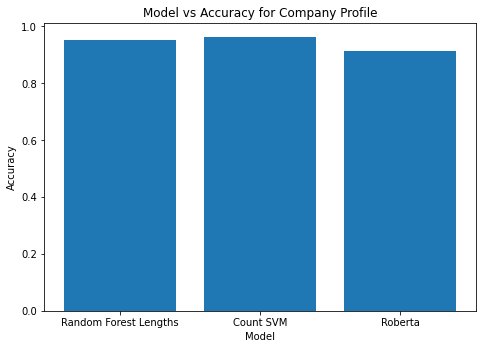

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Random Forest Lengths', 'Count SVM', 'Roberta']
y = [rf_cp_score,cv_cp_score,roberta_cp_mcc]
ax.bar(x,y)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model vs Accuracy for Company Profile")
plt.show()

As can be seen in the plot above, all three models do a very good job of classifying fradulent jobs. Using the count vectorizer and SVM, we get the best performance. The worst would be using Roberta in this case.

#### Description

In [ ]:
# CV SVM
cv_desc_score = cv_prediction_score(x_train, y_train, x_test, y_test, "description")

In [ ]:
# Simpletransformer requires specific format to run
train_df = x_train[["description", "fraudulent"]].fillna("")
train_df.columns = ["text", "labels"]
eval_df = x_test[["description", "fraudulent"]].fillna("")
eval_df.columns = ["text", "labels"]

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

# Base model arguments
model_args = {"overwrite_output_dir": True,
              "manual_seed": 1, # Seed to reproducibility
              "num_train_epochs": 3, # Number of epochs for training
              "learning_rate": 0.00001, # Learning rate for gradients
              "use_early_stopping": True, # Stop early in case of no improvements to speed things up
              "train_batch_size": 4,
              "weight_decay": 0} # L2 regularizer to deal with overfitting

# Create a ClassificationModel
model = ClassificationModel('roberta', 'roberta-base', args = model_args) # You can set class weights by using the optional weight argument

# Train the model
model.train_model(train_df)

# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(eval_df)
roberta_desc_mcc = result['mcc']

- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.



Selected optimization level O1:  Insert automatic casts around Pytorch functions and Tensor methods.

Defaults for this optimization level are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic
Processing user overrides (additional kwargs that are not None)...
After processing overrides, optimization options are:
enabled                : True
opt_level              : O1
cast_model_type        : None
patch_torch_functions  : True
keep_batchnorm_fp32    : None
master_weights         : None
loss_scale             : dynamic


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:114: UserWarning: Seems like `optimizer.step()` has been overridden after learning rate scheduler initialization. Please, make sure to call `optimizer.step()` before `lr_scheduler.step()`. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:231: UserWarning: To get the last learning rate computed by the scheduler, please use `get_last_lr()`.
  warnings.warn("To get the last learning rate computed by the scheduler, "


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 32768.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 16384.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 8192.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 4096.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 2048.0
Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0


/usr/local/lib/python3.6/dist-packages/torch/optim/lr_scheduler.py:200: UserWarning: Please also save or load the state of the optimzer when saving or loading the scheduler.
  warnings.warn(SAVE_STATE_WARNING, UserWarning)


Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 1024.0



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 512.0



Gradient overflow.  Skipping step, loss scaler 0 reducing loss scale to 512.0




INFO:simpletransformers.classification.classification_model: Training of roberta model complete. Saved to outputs/.
INFO:simpletransformers.classification.classification_model: Converting to features started. Cache is not used.


INFO:simpletransformers.classification.classification_model:{'mcc': 0.9633881068047192, 'tp': 439, 'tn': 1161, 'fp': 19, 'fn': 5, 'eval_loss': 0.08984206285478354}


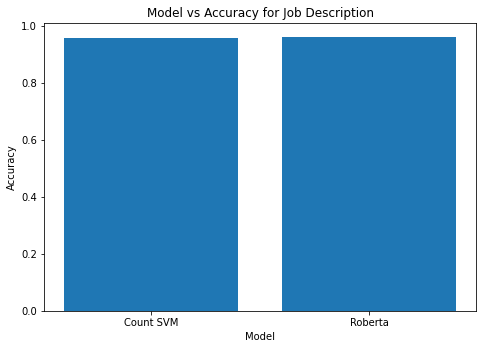

In [ ]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
x = ['Count SVM', 'Roberta']
y = [cv_desc_score,roberta_desc_mcc]
ax.bar(x,y)
plt.xlabel("Model")
plt.ylabel("Accuracy")
plt.title("Model vs Accuracy for Job Description")
plt.show()

As we can see in the plot above, both models do very well in predicting fraudulent jobs from the job description. 

#### Ensemble Model

It seems that simple word counts and SVM do good enough performance. As we have seen earlier, `company_profile`, `description`, `benefits`, and `requirements` all have strong prediction power. As mentioned earlier, `company_profile` and `description` have the strongest power. We can do a simple ensembling of the models to average out our model and deal with potential overfitting for future usage. Word Count and default linear SVM all did very well and will be used with equal weights for all 4 features.

In [160]:
from joblib import dump, load

# Modified function to model
def save_prediction_model(x_train, y_train, var):
  """
  Inputs:
  x_train: Training dataset
  y_train: Predictor values for training
  x_val: Validation/testing dataset
  y_val: Predictor values for testing
  var: Variable in training dataset to tokenize against

  Outputs:
  Save pickled CountVectorizer and 
  """
  cv = CountVectorizer(tokenizer = tokenizer, min_df = 0.01, max_df = 0.99)
  cv1_model = cv.fit_transform(x_train[var].fillna(""))
  dump(cv, 'cv_' + var + '.joblib')  # Save Training CV
  svc = SVC(kernel="linear")
  svc.fit(X = cv1_model, y = y_train)
  dump(svc, 'svc_' + var + '.joblib') # Save Training SVM

In [161]:
# Build training models
for var in ["company_profile", "description", "benefits", "requirements"]:
  save_prediction_model(x_train, y_train, var)

In [188]:
# Prediction model using training data
def predict_svm(x_test, var):
  """
  Inputs:
  x_test: Validation/testing dataset
  var: Variable in training dataset to tokenize against

  Outputs:
  Predicted values
  """
  cv = load('cv_' + var + '.joblib') 
  svc = load('svc_' + var + '.joblib') 
  cv_preds = cv.transform(x_test[var].fillna(""))
  svc_preds = svc.predict(X = cv_preds)
  return(svc_preds)

# Ensemble model by summing predictions and using cutoff of 2 for these 4 classes
def predict_ensemble(x_test):
  """
  Inputs:
  x_test: Validation/testing dataset

  Outputs:
  Predicted value based on equally weighted predictions(n>2 = 1)
  """
  preds = np.zeros((4,x_test.shape[0]))
  preds[0,:] = predict_svm(x_test, "company_profile")
  preds[1,:] = predict_svm(x_test, "description")
  preds[2,:] = predict_svm(x_test, "benefits")
  preds[3,:] = predict_svm(x_test, "requirements")

  return((preds.sum(axis = 0) > 2) * 1) # Get the row based sums of predictions

# Run F1 score to see overall accuracy via sensitivity/specificity
def score_ensemble(x_test, y_test):
  """
  Inputs:
  x_test: Validation/testing dataset
  y_test: Validation/testing prediction values

  Outputs:
  F1 score of ensemble model
  """
  return(f1_score(y_true = y_test, y_pred = predict_ensemble(x_test)))

In [193]:
score_ensemble(x_test[["company_profile", "description", "benefits", "requirements"]], y_test)

0.9369797859690845

As we can see above, the accuracy of this ensemble model is 93.4% which is still strong. The benefits of this approach is that in theory, there is less chance of overfitting as we have weights from different features. The ensembling is equally weighted but could be adjusted more towards a particular feature if necessary.

### Potential Next Steps

There are many potential things that could be done to improve the accuracy of the models. From the data cleaning aspect, there are still many things that could be done in the tokenization aspect. For instance, it looked like the multi-line text was broken done to the nearest word as there are many instances of combined words. From the modeling side, large scale hyper-parametering tuning was not performed. We might be able to squeeze out more performance by changing some fo the hyperparameters. 
Finally, there are still many models that have not been tested yet and could perform better than what is shown here. 

### Conclusion

From the data we are given, it seems that we can reasonably classify if a job is frauduent using multiple features including the company profile from the job description. Although we had a large class imbalance of the data, we employed data augmentation with the text data to artifically bootstrap the data. Although the models seem to suggest that the company profile is the strongest feature, there are other useful features like like the job description, requirements, and benefits which also have good predictive power. We have seen with basic models that we can get good predictive power from text lengths. With basic NLP based models, we get very good accuracy and F1 scoring with minimal training. With more complex models like Roberta, we still get very good performance but it is comparably worse for much longer training times. For the purposes of a strong model, an ensemble model using the best paramters were chosen for the purposes of minimizing potential bias from any particular variable.

### References

1. Bureau of Labor Statistics US Department of Labor. The Employment Situation - June 2020. Accessed 07/26/2020. https://www.bls.gov/news.release/pdf/empsit.pdf  
2. USC Career Center. Avoid Fradulent Job Postings. Accessed 07/26/2020. https://careers.usc.edu/students/find-a-job/avoid-fraudulent-job-postings/  
3. Rajapakse, Thilina. Simple Transformers - Introducing the Easiest Way To Use BERT, RoBERTa, XLNet, and XLM.Accessed 07/26/2020. https://towardsdatascience.com/simple-transformers-introducing-the-easiest-bert-roberta-xlnet-and-xlm-library-58bf8c59b2a3